# Function differentiation

This notebook shows how to differentiate functions represented as MPS using the SeeMPS library. We focus on the finite difference method, since the QFT is not yet optimally implemented to efficiently approximate derivatives. More information about these methods can be found in https://arxiv.org/abs/2303.09430.

First, let us import the necessary set of tools.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seemps.state import MPS
from seemps.analysis.finite_differences import smooth_finite_differences_mpo

The Gaussian function
\begin{equation}
    f(x) = \frac{1}{\mathcal{N}}e^{-x^2/2},
\end{equation}
where $\mathcal{N}$ is normalization constant, acts as benchmark for the differentiation techniques.

Let us define the functions to compute the error.

In [2]:
def remove_phase(v):
    """
    Removes the phase from a complex vector `v` by normalizing it with the phase 
    of its maximum magnitude element.
    
    Parameters
    ----------
    v : numpy.ndarray
        A complex vector or array-like object.

    Returns
    -------
    numpy.ndarray
        A complex vector of the same shape as `v` with its phase removed.
    
    Notes
    -----
    The phase of the vector is adjusted by multiplying it by the conjugate of 
    the element with the maximum magnitude, normalized by the absolute value of 
    that element. This operation effectively rotates the vector to align its 
    largest element with the positive real axis.
    """
    shape = v.shape
    v = v.flatten()
    k = np.argmax(np.abs(v))
    return (v * np.abs(v[k]) / v[k]).reshape(shape)

def norm2_difference(a, b):
    """
    Calculates the norm-2 difference between two vectors or MPS objects after 
    removing their phases and normalizing them.

    Parameters
    ----------
    a : numpy.ndarray or MPS
        The first vector or MPS object.
    b : numpy.ndarray or MPS
        The second vector or MPS object.

    Returns
    -------
    float
        The norm-2 (Euclidean) difference between the two vectors after phase 
        removal and normalization.

    Notes
    -----
    If `a` or `b` are instances of the `MPS` class, they are first converted to 
    vector form using the `to_vector()` method. The vectors are then phase-aligned 
    using the `remove_phase` function and normalized to unit length. The difference 
    is calculated using the Euclidean norm of the difference vector.
    """
    if isinstance(a, MPS):
        a = a.to_vector()
    if isinstance(b, MPS):
        b = b.to_vector()
    a = remove_phase(a)
    b = remove_phase(b)
    a /= np.linalg.norm(a)
    b /= np.linalg.norm(b)
    return np.linalg.norm(a - b)

Let us study the error scaling with the number of qubits $n$, which is equivalent to studying how it varies with $\Delta x$. The finite difference function has a default minimum value of $\Delta x$ to avoid round-off error. This value can be modified according to the problem.

In [3]:
a, b = -10, 10
n_qubits = range(6,23)
f = lambda x: np.exp(- x ** 2)
df = lambda x: - 2 * x * f(x)
errors = np.empty(shape=(len(n_qubits)))

for i, n in enumerate(n_qubits):
    x, dx = np.linspace(a, b, num=2 ** n, endpoint=False, retstep=True)
    f_mps = MPS.from_vector(f(x), [2]*n, normalize=False)
    K = smooth_finite_differences_mpo(n, order=1, filter=9, dx=dx, periodic=True, tol=1e-3)
    errors[i] = norm2_difference((K @ f_mps), df(x))

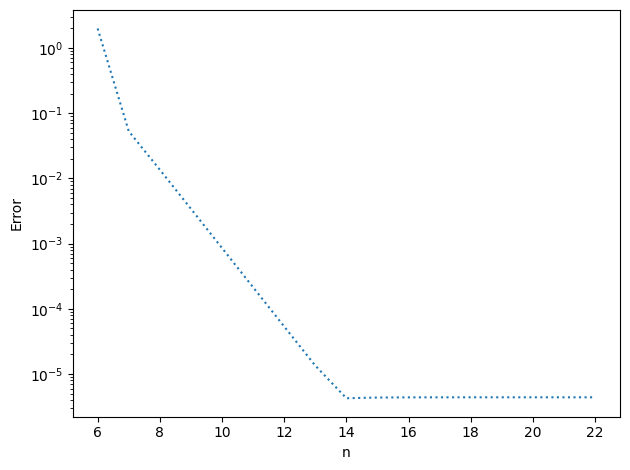

In [4]:
fig, ax = plt.subplots()
ax.set_xlabel('n')
ax.set_ylabel('Error')
ax.set_xticks(n_qubits[::2], n_qubits[::2])
ax.plot(n_qubits, errors, linestyle='dotted')
ax.set_yscale('log')
plt.tight_layout()